In [1]:
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import sys
import os
import pymaster as nmt
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2
from lat_cb.signal import CMB, Foreground, Noise, LATsky,Mask, BandpassInt

In [3]:
lib ='/pscratch/sd/l/lonappan/SOLAT'

# CMB simulation

In [4]:
cmb = CMB(lib,1024,0.35)

In [5]:
E,B = hp.map2alm_spin(cmb.get_cb_lensed_QU(0),2)

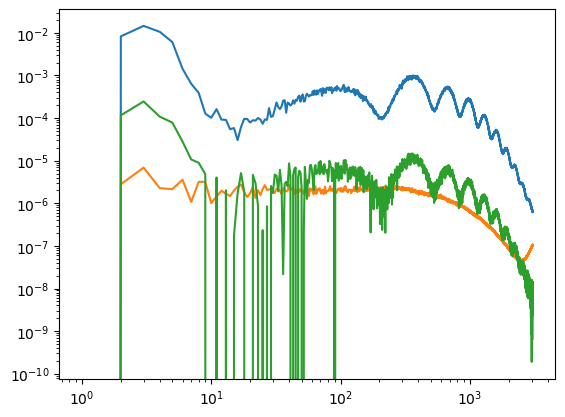

In [6]:
plt.loglog(hp.alm2cl(E),label='E')
plt.loglog(hp.alm2cl(B),label='B')
plt.loglog(hp.alm2cl(E,B),label='EB')

# Bandpass Integration

In [7]:
bp = BandpassInt()

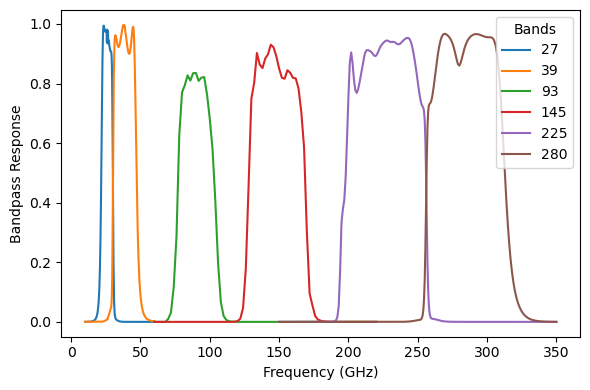

In [8]:
bp.plot_profiles()

# Foreground Simulation

In [10]:
freqs = LATsky.freqs

In [11]:
fg_wobp = Foreground(lib,512,1,1,bandpass=False)
fg_wbp = Foreground(lib,512,1,1,bandpass=True)

In [15]:
d1_wobp = fg_wobp.dustQU('145')
d1_wbp = fg_wbp.dustQU('145')

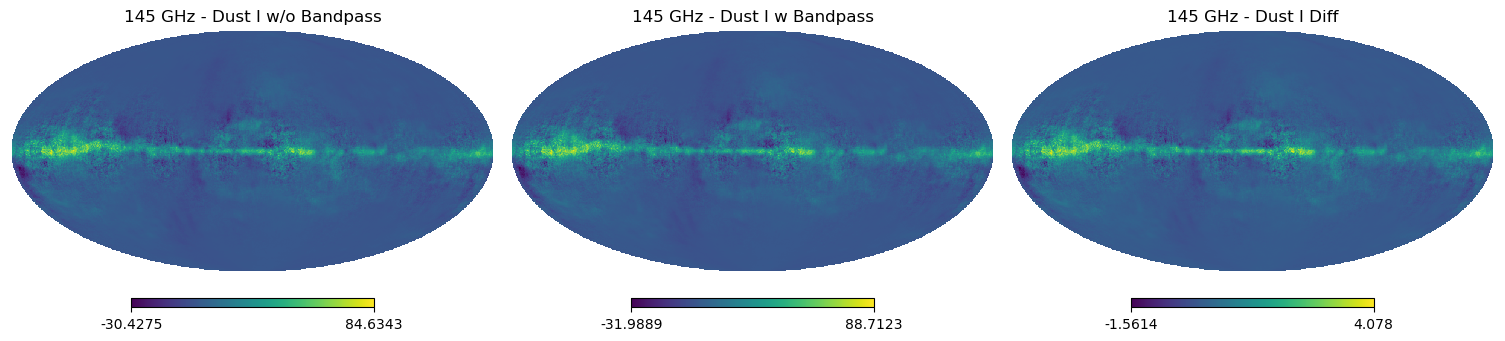

In [16]:
fig = plt.figure(figsize=(15,5))
hp.mollview(d1_wobp[0],title='145 GHz - Dust I w/o Bandpass',sub=(1,3,1))
hp.mollview(d1_wbp[0],title='145 GHz - Dust I w Bandpass',sub=(1,3,2))
hp.mollview(d1_wbp[0]-d1_wobp[0],title='145 GHz - Dust I Diff',sub=(1,3,3))

# Mask

In [4]:
nside = 1024
lmax = 3*nside-1

In [10]:
LatMask = Mask(lib,nside,'LAT')
SatMask = Mask(lib,nside,'SAT')

In [13]:
CommonMask = LatMask * SatMask

In [14]:
print('LAT fsky: ',LatMask.fsky)
print('SAT fsky: ',SatMask.fsky)
print('Common fsky: ',CommonMask.fsky)

LAT fsky:  0.6385857264200846
SAT fsky:  0.3524986108144124
Common fsky:  0.3410397370656331


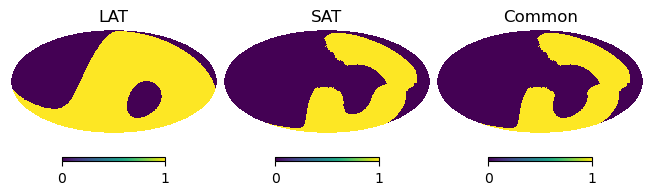

In [15]:
hp.mollview(LatMask.mask, title='LAT', sub=(1,3,1))
hp.mollview(SatMask.mask, title='SAT', sub=(1,3,2))
hp.mollview(CommonMask.mask, title='Common', sub=(1,3,3))

In [16]:
mask = LatMask.mask

In [17]:
wrk = nmt.NmtWorkspace()
mask_f = nmt.NmtField(mask, [mask, mask], lmax=lmax, purify_b=False)
binInfo = nmt.NmtBin.from_lmax_linear(lmax, 10)
wrk.compute_coupling_matrix(mask_f, mask_f, binInfo)

def compute_master(f_a,f_b):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wrk.decouple_cell(cl_coupled)
    return cl_decoupled
    
b = binInfo.get_effective_ells()

# Noise Simulation - white noise

In [18]:
n = Noise(nside,fsky=LatMask.fsky,atm_noise=False)

Noise Model: White noise v3.0.0


In [19]:
qus = n.noiseQU()

In [20]:
q27,u27 = qus[0]
q39,u39 = qus[1]

In [21]:
f27 = nmt.NmtField(mask, [q27,u27],lmax=n.lmax, purify_b=False)
f39 = nmt.NmtField(mask, [q39,u39],lmax=n.lmax, purify_b=False)

In [22]:
ee27,_,_,bb27 = compute_master(f27,f27)
ee39,_,_,bb39 = compute_master(f39,f39)

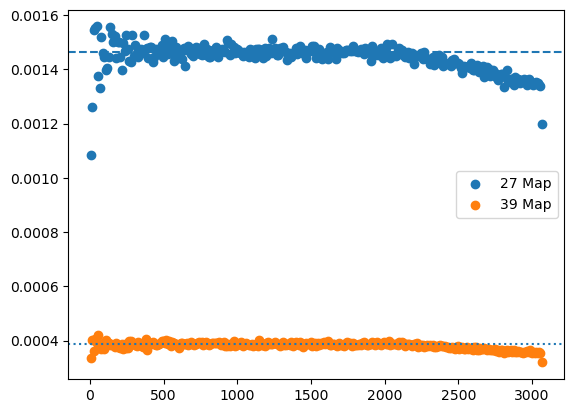

In [35]:

plt.scatter(b,ee27,label='27 Map')
plt.scatter(b,ee39,label='39 Map')
plt.axhline(n.Nell['27'][0]*2,ls='--')
plt.axhline(n.Nell['39'][0]*2,ls=':')
plt.legend()

# Noise Simulation - 1/f

In [38]:
n = Noise(nside,fsky=LatMask.fsky,atm_noise=True)

Noise Model: Atmospheric noise v3.0.0


In [40]:
qus = n.noiseQU()

In [41]:
q27,u27 = qus[0]
q39,u39 = qus[1]

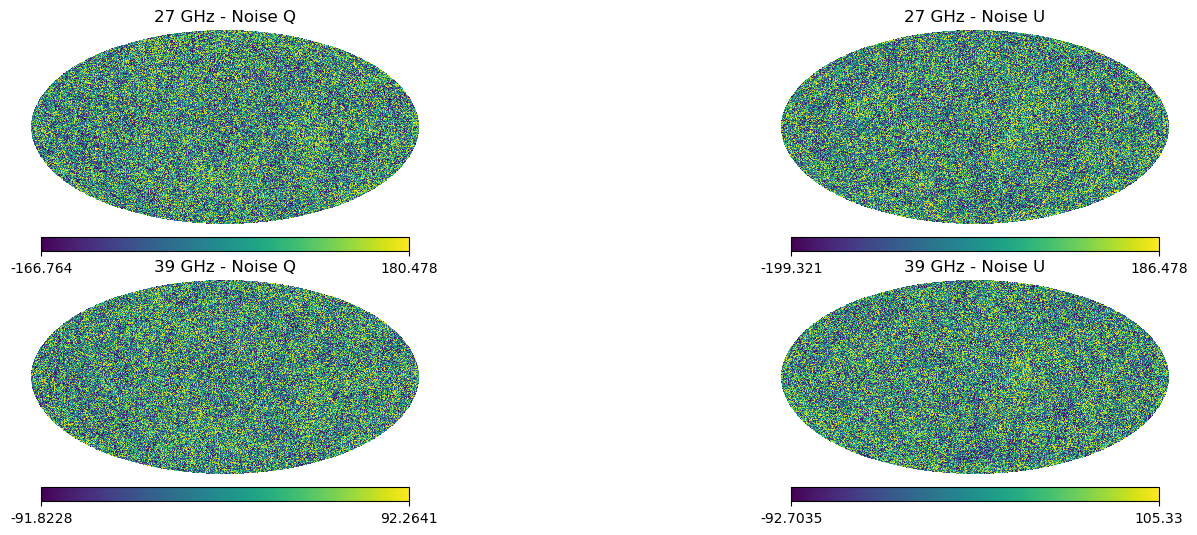

In [42]:
plt.figure(figsize=(15,10))
hp.mollview(q27,title='27 GHz - Noise Q',sub=(4,2,1),norm='hist')
hp.mollview(u27,title='27 GHz - Noise U',sub=(4,2,2),norm='hist')
hp.mollview(q39,title='39 GHz - Noise Q',sub=(4,2,3),norm='hist')
hp.mollview(u39,title='39 GHz - Noise U',sub=(4,2,4),norm='hist')

In [43]:
f27 = nmt.NmtField(mask, [q27,u27],lmax=n.lmax, purify_b=False)
f39 = nmt.NmtField(mask, [q39,u39],lmax=n.lmax, purify_b=False)

In [44]:
ee27,_,_,bb27 = compute_master(f27,f27)
ee39,_,_,bb39 = compute_master(f39,f39)
ee27_39,_,_,bb27_39 = compute_master(f27,f39)

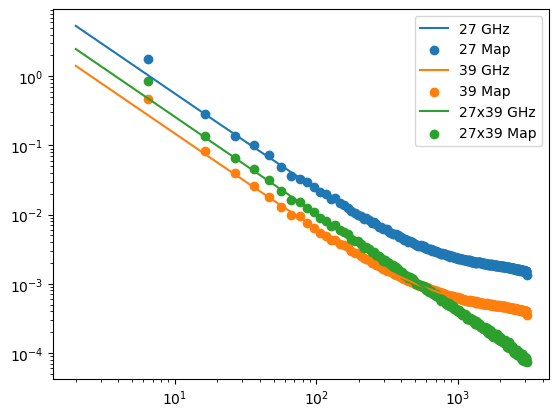

In [45]:
plt.loglog(n.Nell['ell'],n.Nell['27']*2,label='27 GHz')
plt.scatter(b,ee27,label='27 Map')
plt.loglog(n.Nell['ell'],n.Nell['39']*2,label='39 GHz')
plt.scatter(b,ee39,label='39 Map')
plt.loglog(n.Nell['ell'],n.Nell['27x39']*2,label='27x39 GHz')
plt.scatter(b,ee27_39,label='27x39 Map')
plt.legend()

In [47]:
alpha = [0.1,0.1,0.3,0.3,.2,.2]

In [52]:
lat = LATsky(lib,512,0.35,1,1,alpha)

Noise Model: White noise v3.0.0


In [53]:
lat.config

{'27-1': {'fwhm': 7.4, 'alpha': 0.1},
 '39-1': {'fwhm': 5.1, 'alpha': 0.1},
 '93-1': {'fwhm': 2.2, 'alpha': 0.3},
 '145-1': {'fwhm': 1.4, 'alpha': 0.3},
 '225-1': {'fwhm': 1.0, 'alpha': 0.2},
 '280-1': {'fwhm': 0.9, 'alpha': 0.2},
 '27-2': {'fwhm': 7.4, 'alpha': 0.1},
 '39-2': {'fwhm': 5.1, 'alpha': 0.1},
 '93-2': {'fwhm': 2.2, 'alpha': 0.3},
 '145-2': {'fwhm': 1.4, 'alpha': 0.3},
 '225-2': {'fwhm': 1.0, 'alpha': 0.2},
 '280-2': {'fwhm': 0.9, 'alpha': 0.2}}

In [54]:
obsmap = lat.obsQU(0,'27-1')

Saving Observed QUs: 100%|██████████| 12/12 [00:02<00:00,  4.20band/s]


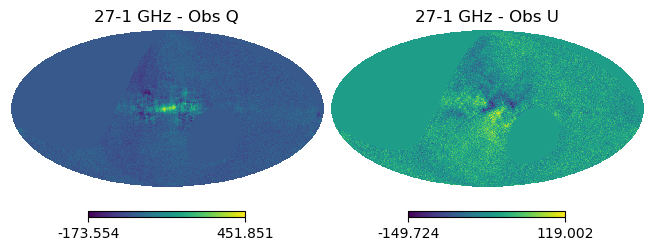

In [55]:
hp.mollview(obsmap[0],title='27-1 GHz - Obs Q',sub=(1,2,1))
hp.mollview(obsmap[1],title='27-1 GHz - Obs U',sub=(1,2,2))